## Results for Example Mice

In [1]:
import set_path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy import signal
from scipy import linalg
from scipy import stats
from scipy.fftpack import fft, ifft
import scipy.io as sio
import os
import shutil
from scipy.interpolate import interp1d
from scipy.stats import pearsonr
import pickle
import copy
import random
import nrrd
from pathlib import Path
from statsmodels.stats.proportion import proportions_ztest
import seaborn as sns

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi
from allensdk.core.structure_tree import StructureTree
from allensdk.api.queries.mouse_connectivity_api import MouseConnectivityApi

from utils import *
from settings import settings
from hyperparams import *

In [2]:
cache = EcephysProjectCache.from_warehouse(manifest=settings.observatory.manifest_path)
sessions = cache.get_session_table()
channels = cache.get_channels()
units = cache.get_units()

session_fc_ids = sessions[sessions['session_type']=='functional_connectivity'].index.values
session_used = np.setdiff1d(session_fc_ids,settings.observatory.sess_removed)

In [3]:
def extract_seg(sig,centers,hwinsz):
    """ extract segments from signals """
    
    if sig.ndim == 2:
        seg = np.zeros((hwinsz*2+1,sig.shape[1],centers.size))
        for cnt in range(centers.size):
            seg[:,:,cnt] = sig[centers[cnt]-hwinsz:centers[cnt]+hwinsz+1,:]
        return seg
    elif sig.ndim == 1:     
        seg = np.zeros((hwinsz*2+1,centers.size))
        for cnt in range(centers.size):
            seg[:,cnt] = sig[centers[cnt]-hwinsz:centers[cnt]+hwinsz+1]
        return seg
    else:
        sys.exit('ndim of sig musts be either 1 or 2')

In [4]:
def ripple_detection(sig, sr):
    """ return ripple event mask and ripple peak index 
        input:
            sig: lfp data in the form of N time points and M channels
            sr: sampling rate of the lfp signal
    """
    lowB = 80
    highB = 250
    SDthr = 5
    b1, a1 = signal.butter(2, Wn = [lowB/sr*2, highB/sr*2], btype = "bandpass")
    b2, a2 = signal.butter(2, Wn = (lowB+highB)/2/3.1415926/sr*2, btype = "lowpass")
    ripplemsk = []
    ripplectrind = []
    sig = signal.filtfilt(b1, a1, sig, axis=0,method="gust") 
    for cnt in range(sig.shape[1]):
        org = sig[:,cnt]
        clipped = np.clip(org,org.mean()-org.std()*SDthr,org.mean()+org.std()*SDthr)
        clipped_pw = signal.filtfilt(b2, a2, abs(clipped),axis=0,method='gust')
        org_pw = signal.filtfilt(b2, a2, abs(org),axis=0,method='gust')

        sd5msk = (org_pw>(clipped_pw.mean()+clipped_pw.std()*SDthr)).astype(int)
        sd5msk[[0,-1]]=0
        # remove small ripple mask (<15ms)
        sd5msk_diff = np.diff(sd5msk)
        sd5startind = np.asarray(np.where(sd5msk_diff==1)).squeeze()+1
        sd5endind = np.asarray(np.where(sd5msk_diff==-1)).squeeze()+1
        sd5blksz = sd5endind-sd5startind
        for cnt2 in range(sd5blksz.shape[0]):
            if sd5blksz[cnt2] < 15/1000*sr:
                sd5msk[sd5startind[cnt2]:sd5endind[cnt2]]=0
        # merge ripple mask with a small gap (<15ms)
        sd5msk_diff = np.diff(sd5msk)
        sd5startind = np.asarray(np.where(sd5msk_diff==1)).squeeze()+1
        sd5endind = np.asarray(np.where(sd5msk_diff==-1)).squeeze()+1
        if sd5startind.size>1:
            sd5gapsz = sd5startind[1:]-sd5endind[:-1]
            for cnt3 in range(sd5gapsz.size):
                if sd5gapsz[cnt3] < 15/1000*sr:
                    sd5msk[sd5endind[cnt3]:sd5startind[cnt3+1]]=1
        else:
            sd5msk = np.zeros(sd5msk.shape)
            
        ripplepwpksind, _ = signal.find_peaks(sd5msk*org_pw)
        
        sd2msk = (org_pw>(clipped_pw.mean()+clipped_pw.std()*2)).astype(int)
        sd2msk[[0,-1]]=0
        sd2msk_diff = np.diff(sd2msk)
        sd2startind = np.asarray(np.where(sd2msk_diff==1)).squeeze()+1
        sd2endind = np.asarray(np.where(sd2msk_diff==-1)).squeeze()+1
        for cnt4 in range(sd2startind.size):
            if np.sum((ripplepwpksind-sd2startind[cnt4])*(ripplepwpksind-sd2endind[cnt4])<0)==0:
                sd2msk[sd2startind[cnt4]:sd2endind[cnt4]]=0
        print('processed channel [{:d}|{:d}]'.format(cnt+1, sig.shape[1]))
        ripplemsk.append(sd2msk*org_pw)
        
        if ripplepwpksind.size==0:
            ripplectrind.append(np.nan)
        else:
            hfnpks, _ = signal.find_peaks(-org)
            ripplectrind.append(hfnpks[np.abs(np.subtract.outer(hfnpks, ripplepwpksind)).argmin(0)])
            
    return ripplemsk, ripplectrind    

In [5]:
def phaseScrambleTS(ts):
    """Returns a TS: original TS power is preserved; TS phase is shuffled."""
    fs = fft(ts)
    pow_fs = np.abs(fs) ** 2.
    phase_fs = np.angle(fs)
    phase_fsr = phase_fs.copy()
    phase_fsr_lh = phase_fsr[1:np.ceil(len(phase_fsr)/2).astype(int)]
    np.random.shuffle(phase_fsr_lh)
    phase_fsr_rh = -phase_fsr_lh[::-1]
    phase_fsr[1:np.ceil(len(phase_fsr)/2).astype(int)] = phase_fsr_lh.copy()
    phase_fsr[int(len(phase_fsr)/2+1):] = phase_fsr_rh.copy()
    fsrp = np.sqrt(pow_fs) * (np.cos(phase_fsr) + 1j * np.sin(phase_fsr))
    tsr = np.real(ifft(fsrp))
    return tsr

In [6]:
def fano(sig,winsize):
    if np.floor(winsize/2) == winsize/2:
        sys.exit('Put an odd number for window size')
    hsz = int(np.floor(winsize/2))
    ff = np.zeros(sig.shape)
    for ind in range(hsz,sig.size-hsz):
        tmp = sig[ind-hsz:ind+hsz].values
        ff[ind] = np.var(tmp)/np.mean(tmp)
    ff[0:hsz] = ff[hsz]
    ff[sig.size-hsz:]=ff[sig.size-hsz-1]
    return ff    

In [7]:
pthr_corr = 0.001
pthr_mean = 0.001
pthr_corr_ctrl = 0.05

sid  = session_used[1]

""" load data """
sessDir = settings.projectData.dir.sessions / 'session_{:d}'.format(sid)

varName = 'rsData1'
fName = getattr(settings.projectData.files.sessions, varName)
fPath = sessDir / fName
with open(fPath, 'rb') as handle:
    rsData = pickle.load(handle)

varName = 'lfpData'
fName = getattr(settings.projectData.files.sessions, varName)
fPath = sessDir / fName
with open(fPath, 'rb') as handle:
    lfpData = pickle.load(handle)

varName = 'sessData'
fName = getattr(settings.projectData.files.sessions, varName)
fPath = sessDir / fName
with open(fPath, 'rb') as handle:
    sessData = pickle.load(handle)

varName = 'flData'
fName = getattr(settings.projectData.files.sessions, varName)
fPath = sessDir / fName
with open(fPath, 'rb') as handle:
    flData = pickle.load(handle)

varName = 'dgrData'
fName = getattr(settings.projectData.files.sessions, varName)
fPath = sessDir / fName
with open(fPath, 'rb') as handle:
    dgrData = pickle.load(handle)

### Mouse Template

In [8]:
mcc = MouseConnectivityCache(resolution = 25, 
                             manifest_file = settings.connectivity.manifest_path)
oapi = OntologiesApi()
structure_tree = mcc.get_structure_tree()

name_map = structure_tree.get_name_map() # dictionary mapping ids to structure names
acrnm_map = structure_tree.get_id_acronym_map() # dictionary mapping acronyms to ids
colormap = structure_tree.get_colormap() # the colormap used for the allen 3D mouse atlas ontology
id_map = structure_tree.value_map(lambda x: x['id'], lambda y: y['acronym'])

### Synchronization

In [9]:
""" fano factor """
gls0 = rsData.spikect.sum(axis=1)
ff = fano(gls0, 11)

""" cross-correlation """
cctime = np.arange(0,101)*.2-10
cctmsk = (cctime>-12) & (cctime<12)

spikect2f_qt = rsData.spikect2f[rsData.qtmsk==1,:].copy()
qtlen = spikect2f_qt[250:-250,:].shape[0]

cc_gls = [];# cc function of real signal
sig = spikect2f_qt[250:-250,:].copy()
sig = signal.detrend(sig,axis=0)
for ind in range(0,sig.shape[1]):
    tmp = sig[:,ind]
    gls = np.concatenate([sig[:,0:ind], sig[:,ind+1:]], axis=1).mean(axis=1)
    tmp2 = np.correlate((tmp-tmp.mean())/tmp.std()/len(tmp),(gls-gls.mean())/gls.std(),'full')
    cc_gls.append(tmp2[qtlen-50:qtlen+51])
cc_gls = np.array(cc_gls)

spikect2f_qtps = rsData.spikect2f[rsData.qtmsk==1,:].copy()
for cnt in range(0,spikect2f_qtps.shape[1]):
    spikect2f_qtps[:,cnt] = phaseScrambleTS(spikect2f_qtps[:,cnt])

cc_gls_c2 = []; # cc functional of shufffled signal with gs being the mean of phase shuffled signals
sig = spikect2f_qtps[250:-250,:].copy()
sig = signal.detrend(sig,axis=0)

for ind in range(0,sig.shape[1]):
    tmp = sig[:,ind]
    glssig2 = np.concatenate([sig[:,0:ind], sig[:,ind+1:]], axis=1).mean(axis=1)
    tmp2 = np.correlate((tmp-tmp.mean())/tmp.std()/len(tmp),(glssig2-glssig2.mean())/glssig2.std(),'full')
    cc_gls_c2.append(tmp2[qtlen-50:qtlen+51])
cc_gls_c2 = np.array(cc_gls_c2)

ccsind = np.argsort(abs(cc_gls[:,cctmsk]).argmax(axis=1))
pkt = cctime[abs(cc_gls[:,:]).argmax(axis=1)]
ccsind_c2 = np.argsort(abs(cc_gls_c2[:,cctmsk]).argmax(axis=1))
pkt_c2 = cctime[abs(cc_gls_c2[:,:]).argmax(axis=1)]

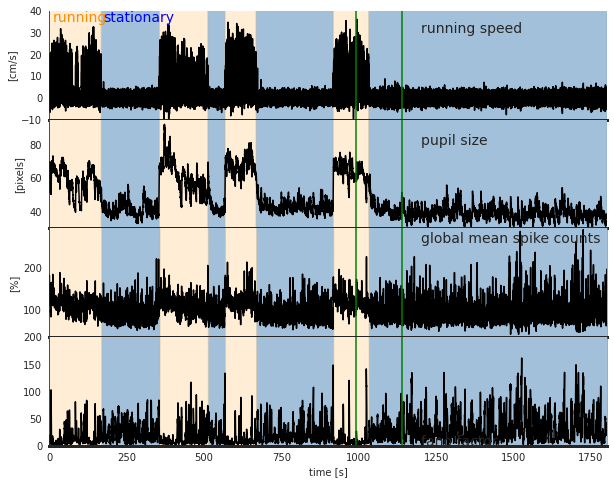

In [10]:
sns.set_style('white')
fig, axs = plt.subplots(4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},
                        figsize=(10,8))
(ax1, ax2,ax3, ax4) = axs

ax1.plot(rsData.running_time,rsData.running_speed,'k',label='running speed')
ax1.set_ylim(-10,40)
ax1.set_ylabel('[cm/s]')
ax1.text(1200,30,'running speed',fontsize=14)
ax1.text(10,35,'running',fontsize=14,color='darkorange')
ax1.text(175,35,'stationary',fontsize=14,color='blue')
ax2.plot(rsData.pupil_time,rsData.pupil_size,'k',label='pupil size')
ax2.set_ylim(30,95)
ax2.set_ylabel('[pixels]')
ax2.text(1200,80,'pupil size',fontsize=14)
ax3.plot(rsData.spikect2.time_relative_to_stimulus_onset,rsData.gls*100,'k',label='the mean spike rate')
ax3.set_ylim(35,295)
ax3.set_ylabel('[%]')
ax3.text(1200,260,'global mean spike counts',fontsize=14)
ax4.plot(rsData.spikect2.time_relative_to_stimulus_onset,ff,'k', label='fano factor')
ax4.set_ylim(0,200)
ax4.set_xlabel('time [s]')
ax4.text(1200,0.4,'fano factor',fontsize=14)

for num, ax in enumerate(axs):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.set_xlim(0,rsData.pupil_time[-1])
    ax.fill_between(rsData.spikect2.time_relative_to_stimulus_onset,
                    rsData.qtmsk*-30,rsData.qtmsk*350,color='steelblue',alpha=0.5)
    ax.fill_between(rsData.spikect2.time_relative_to_stimulus_onset,
                    (1-rsData.qtmsk)*-30,(1-rsData.qtmsk)*350,color='navajowhite',alpha=0.5)
    ax.axvline(990,color='g')
    ax.axvline(1140,color='g')

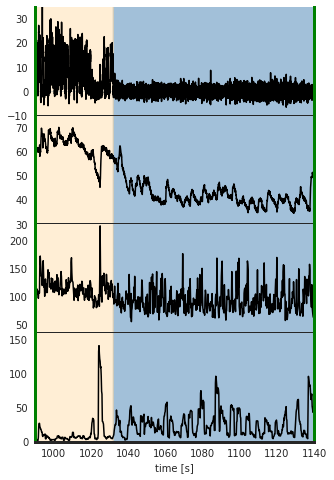

In [11]:
fig, axs = plt.subplots(4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},
                        figsize=(5,8))
(ax1, ax2,ax3, ax4) = axs
ax2.plot(rsData.pupil_time,rsData.pupil_size,'k',label='pupil size')
ax2.set_ylim(30,75)
# ax2.set_ylabel('[pixels]')
ax1.plot(rsData.running_time,rsData.running_speed,'k',label='running speed')
ax1.set_ylim(-10,35)
# ax1.set_ylabel('[cm/s]')
ax3.plot(rsData.spikect2.time_relative_to_stimulus_onset,rsData.gls*100,'k',label='the mean spike counts')
ax3.set_ylim(35,230)
# ax3.set_ylabel('[%]')
ax4.plot(rsData.spikect2.time_relative_to_stimulus_onset,ff,'k', label='fano factor')
ax4.set_ylim(0,160)
ax4.set_xlabel('time [s]')

for num, ax in enumerate(axs):
    # ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(990,1140)
    ax.fill_between(rsData.spikect2.time_relative_to_stimulus_onset,
                    rsData.qtmsk*-30,rsData.qtmsk*350,color='steelblue',alpha=0.5)
    ax.fill_between(rsData.spikect2.time_relative_to_stimulus_onset,
                    (1-rsData.qtmsk)*-30,(1-rsData.qtmsk)*350,color='navajowhite',alpha=0.5)
    ax.spines['right'].set_color('g')
    ax.spines['left'].set_color('g')
    ax.spines['right'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

Note: The following result involve random permutation. It may be slightly difference from the results shown in the paper

<ipython-input-12-1973ad95b19c>:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


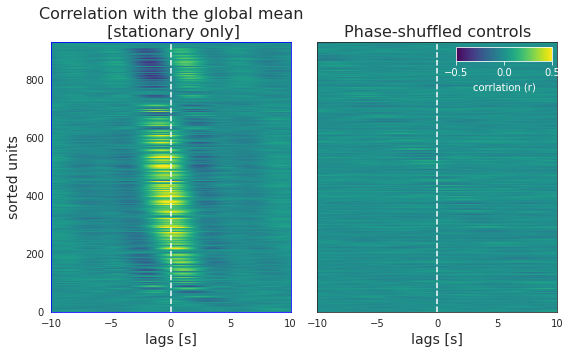

In [12]:
sns.set_style('white')
fig,axes = plt.subplots(1,2,figsize=(8,5))
axes[0].imshow((cc_gls[ccsind,:]),vmin=-.5, vmax=.5,
               aspect='auto',cmap = 'viridis',extent = [-10,10,0,cc_gls.shape[0]])
axes[0].set_title('Correlation with the global mean\n [stationary only]',fontsize=16)
# axes[0].set_xticks([])
axes[0].set_xlabel('lags [s]',fontsize=14)
axes[0].set_ylabel('sorted units',fontsize=14)
axes[0].axvline(0,linestyle = '--',color='w')

axes[0].spines['right'].set_color('b')
axes[0].spines['left'].set_color('b')
axes[0].spines['top'].set_color('b')
axes[0].spines['bottom'].set_color('b')

im = axes[1].imshow(cc_gls_c2[ccsind_c2,:],vmin=-.5, vmax=.5,
                    aspect='auto',cmap = 'viridis',extent = [-10,10,0,cc_gls.shape[0]])
axes[1].set_xlabel('lags [s]',fontsize=14)
axes[1].set_title('Phase-shuffled controls',fontsize=16)
axes[1].set_ylabel('')
axes[1].set_yticks([])
axes[1].axvline(0,linestyle = '--',color='w')

axins1 = inset_axes(axes[1], width="40%",  height="5%",loc='upper right')
cb = fig.colorbar(im,cax=axins1,orientation='horizontal')
cb.ax.xaxis.set_tick_params(color='w')
cb.outline.set_edgecolor('w')
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')
cb.set_label('corrlation (r)', color='w')
fig.tight_layout(pad=1)

### Measurement around neural cascade 

In [13]:
corrthr = np.tanh(stats.norm.ppf(1 - pthr_corr/2) / np.sqrt(sum(rsData.glsnind)  - 3))
corrthr_ctrl = np.tanh(stats.norm.ppf(1 - pthr_corr_ctrl/2) / np.sqrt(sum(rsData.glsnind) - 3))

dprfsn_sgnf = rsData.dprfsn[:,rsData.dlycor>corrthr]
delay_tscore, delay_signp = stats.ttest_1samp(dprfsn_sgnf.T, 0)
delay_signp = delay_signp * np.sign(delay_tscore)

negumsk = (delay_signp > -pthr_mean) & (delay_signp < 0)
posumsk = (delay_signp < pthr_mean) & (delay_signp > 0)
negct2 = rsData.spikect2[:,negumsk].mean(axis=1)
posct2 = rsData.spikect2[:,posumsk].mean(axis=1)

posonsetind,_,_ = stats.binned_statistic(np.arange(posct2.size-1), np.diff(posct2), statistic=np.argmax, bins=rsData.npks)
posonsetind = posonsetind.astype(int) + rsData.npks[:-1]

twin = 20
time_segct = (np.arange(2*twin) - twin) * rsData.tstep
spkctseg = extract_seg(rsData.spikect2, posonsetind, twin)
segmean = spkctseg[:,:,rsData.dlycor>corrthr].mean(axis=2)
segpks = np.argmax(segmean[:31,:],axis=0)
segtime = time_segct[:31]

lm = stats.linregress(rsData.U[:,0], segtime[segpks])
delay_sec = rsData.U[:,0] * lm.slope

unitdf = rsData.unitdf

unitdf['delay_tscore'] = delay_tscore
unitdf['delay_sec'] = delay_sec
unitdf['delay_signp'] = delay_signp

""" resting-state neuron activity vs running """
running_spkdiff= rsData.spikect2[rsData.qtmsk==0,:].mean(axis=0) - rsData.spikect2[rsData.qtmsk==1,:].mean(axis=0)

running_speed_spk, _, _ = stats.binned_statistic(rsData.running_time, 
                                                 abs(rsData.running_speed), 
                                                 statistic=np.nanmean, bins=rsData.tbins)
m = ~np.isnan(running_speed_spk)
rscorr = np.corrcoef(rsData.spikect2[m,:].T, running_speed_spk[m])[:-1,-1]
m = m & (rsData.qtmsk == 1)
rscorr_qt = np.corrcoef(rsData.spikect2[m,:].T, running_speed_spk[m])[:-1,-1]

running_tscore, running_signp = stats.ttest_ind(rsData.spikect2[rsData.qtmsk == 0,:], 
                                                rsData.spikect2[rsData.qtmsk == 1,:])
running_signp = running_signp * np.sign(running_tscore)

unitdf['running_spkdiff'] = running_spkdiff
unitdf['rscorr'] = rscorr
unitdf['rscorr_qt'] = rscorr_qt
unitdf['running_tscore'] = running_tscore
unitdf['running_signp'] = running_signp

""" resting-state neuron activity vs pupil size """
pupil_size_spk, _, _ = stats.binned_statistic(rsData.pupil_time, 
                                          rsData.pupil_size, 
                                          statistic=np.nanmean, bins=rsData.tbins)
m = ~np.isnan(pupil_size_spk)
pscorr = np.corrcoef(rsData.spikect2[m,:].T, pupil_size_spk[m])[:-1,-1]
m = m & (rsData.qtmsk == 1)
pscorr_qt = np.corrcoef(rsData.spikect2[m,:].T, pupil_size_spk[m])[:-1,-1]

unitdf['pscorr'] = pscorr
unitdf['pscorr_qt'] = pscorr_qt

""" measurements around positive neuron onset """
glspksind_dp = np.abs(np.subtract.outer(lfpData.rs_lfpVISdp.time.values, 
                                        rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
glspksind_pupil = np.abs(np.subtract.outer(rsData.pupil_time, 
                                           rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
glspksind_run = np.abs(np.subtract.outer(rsData.running_time, 
                                         rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)
glspksind_rm = np.abs(np.subtract.outer(lfpData.CA1time, 
                                        rsData.gls.time_relative_to_stimulus_onset[posonsetind].values)).argmin(0)

segqtmsk = stats.binned_statistic(np.arange(rsData.qtmsk.size),
                                  rsData.qtmsk, statistic='mean', bins=rsData.npks).statistic

samsk = (rsData.dlycor > corrthr) & (segqtmsk == 1) # segments includes cascade evenets
ctlmsk = (abs(rsData.dlycor) < pthr_corr_ctrl) & (segqtmsk == 1) # segements for control 

# ripple event around positive neuron onset
ripplemsk = lfpData.ripplemsk[:,lfpData.chn]
ripplemsk[ripplemsk.nonzero()] = 1
rpseg = extract_seg(ripplemsk, glspksind_rm, 5000)
rpmean = rpseg[:,samsk==1].mean(axis=1)
rpmean_ctrl = rpseg[:,ctlmsk==1].mean(axis=1)

# delta wave around positive neuron onset
dpw = lfpData.rs_lfpVISdp.mean(axis=1)
qtmskdpw = np.interp(dpw.time, rsData.running_time, rsData.qtmskorg)
qtmskdpw = np.round(qtmskdpw)
dpwn = dpw / dpw.mean()
dpseg = extract_seg(dpwn, glspksind_dp, 500)
dpmean = dpseg[:,samsk].mean(axis=1)
dpmean_ctrl = dpseg[:,ctlmsk].mean(axis=1)

# pupil size around positive neuron onset
qtmskpp = np.interp(rsData.pupil_time, rsData.running_time, rsData.qtmskorg)
qtmskpp = np.round(qtmskpp)
rs_pupil_sizen = rsData.pupil_size / np.nanmean(rsData.pupil_size)
pupilseg = extract_seg(rs_pupil_sizen, glspksind_pupil, 120)
pmean = np.nanmean(pupilseg[:,samsk],axis=1)
pmean_ctrl = np.nanmean(pupilseg[:,ctlmsk],axis=1)

# running speed around positive neuron onset
runseg = extract_seg(rsData.running_speed, glspksind_run, 160)
rmean = np.nanmean(runseg[:,samsk],axis=1)
rmean_ctrl = np.nanmean(runseg[:,ctlmsk],axis=1)
if sid ==821695405:
    tmp = runseg[:,samsk].copy()
    tmp = tmp[:,tmp.mean(axis=0)<0.2]
    rmean = np.nanmean(tmp,axis=1)

# positive-delay neuron activity around positive neuron onset
posseg = extract_seg(posct2, posonsetind, 20)
posmean = np.nanmean(posseg[:,samsk],axis=1)
posmean_ctrl = np.nanmean(posseg[:,ctlmsk],axis=1)

# negative-delay neuron activity around positive neuron onset
negseg = extract_seg(negct2, posonsetind, 20)
negmean = np.nanmean(negseg[:,samsk],axis=1)
negmean_ctrl = np.nanmean(negseg[:,ctlmsk],axis=1)

In [14]:
time_segct = (np.arange(41)-20)/5
time_segpupil = (np.arange(241)-120)/30
time_segrun = (np.arange(321)-160)/40
time_segdp = (np.arange(1001)-500)*10/1249.99839649285
time_segrp = (np.arange(10001)-5000)/1249.99839649285

AmpF = 100

In [15]:
session_data = cache.get_session_data(sid)
probesid = session_data.probes.index.values
sr = session_data.probes.lfp_sampling_rate.values[0]

lfp0 = session_data.get_lfp(probesid[0]).sel(time=slice(rsData.tstart, rsData.tstop))
lfp0 = lfp0.assign_coords(time=lfp0.time-rsData.tstart)

chanid = lfp0.channel.values
chanloc = channels.loc[chanid,'ecephys_structure_acronym']
lfp0 = lfp0.drop_sel(channel=chanid[np.where(chanloc.str.match('NaN'))])
chanid = lfp0.channel.values
chanloc = channels.loc[chanid,'ecephys_structure_acronym']

lfp0VIS = lfp0.sel(channel=chanid[np.where(chanloc.str.match('VIS'))])
lfp0CA1 = lfp0.sel(channel=chanid[np.where(chanloc.str.match('CA1'))])

b3, a3 = signal.butter(3, Wn =[.5/sr*2, 4/sr*2], btype = "bandpass")
lfp0VISflt = signal.filtfilt(b3, a3, lfp0VIS, axis=0, method="gust") 

lfp0VISflt = xr.DataArray(lfp0VISflt, coords=[lfp0VIS.time,lfp0VIS.channel])
lfp0VISflt = lfp0VISflt.coarsen(time=10, boundary='trim').mean()

In [16]:
f_spcseg, t_spcseg, Sxx = signal.spectrogram(lfpData.rprawseg, fs=sr, nperseg=256, noverlap=250,
                                             axis=0, window=('dpss',1.5)); 
logSxx = np.log10(Sxx) * 10
logSxx=logSxx.transpose((2, 1, 0))
nlogSxx = logSxx-logSxx[1:20,:,:].mean(axis=0)
spgseg=nlogSxx.transpose((1, 2, 0))

<ipython-input-17-e36988f0679b>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


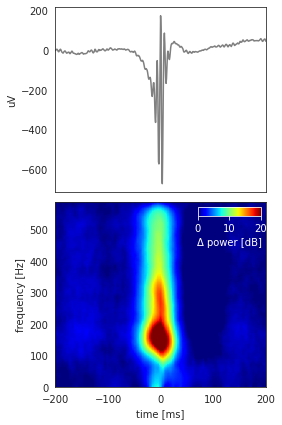

In [17]:
fig,axes = plt.subplots(2,1,figsize =(4,6))
axes[0].plot(lfpData.rprawseg_t*1e3,-lfpData.rprawseg.mean(axis=1)*1e6,'gray')
# axes[0].set_xlabel('time [ms]')
axes[0].set_xticks([])
axes[0].set_ylabel('uV')
axes[0].set_xlim(-200,200)
im = axes[1].imshow(spgseg[:,0:120,:].mean(axis=0),
                    vmin = 0,vmax=20,aspect='auto',cmap = 'jet',
                    extent=[(t_spcseg[0]-t_spcseg[len(t_spcseg)//2])*1000,
                            (t_spcseg[-1]-t_spcseg[len(t_spcseg)//2])*1000,
                            f_spcseg[120],f_spcseg[0]])
axes[1].set_xlabel('time [ms]')
axes[1].set_ylabel('frequency [Hz]')
axes[1].invert_yaxis()
axes[1].set_xlim(-200,200)

axins1 = inset_axes(axes[1], width="30%",  height="5%",loc='upper right')
cb = fig.colorbar(im,cax=axins1,orientation='horizontal')
cb.ax.xaxis.set_tick_params(color='w')
cb.outline.set_edgecolor('w')
plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')
cb.set_label('\u0394 power [dB]', color='w')
fig.tight_layout(pad=1)

In [18]:
lowB = 80
highB = 250
b1, a1 = signal.butter(2, Wn = [lowB/sr*2, highB/sr*2], btype = "bandpass")
b2, a2 = signal.butter(2, Wn = (lowB+highB)/2/3.1415926/sr*2, btype = "lowpass")
sig = signal.filtfilt(b1, a1, lfp0CA1[:,11], axis=0,method="gust") 
org_pw = signal.filtfilt(b2, a2, abs(sig),axis=0,method='gust')

rpexpmsk, rpexpind = ripple_detection(lfp0CA1.copy(),sr)

f, t, Sxx = signal.spectrogram(lfp0CA1.values[:,11],fs=sr,nperseg = 1024,noverlap = 1024*0.8); # option: window = ('dpss',3.5)
logSxx = np.log10(Sxx)*10
nlogSxx = (logSxx.T-logSxx.mean(axis=1).T).T

processed channel [1|15]
processed channel [2|15]
processed channel [3|15]
processed channel [4|15]
processed channel [5|15]
processed channel [6|15]
processed channel [7|15]
processed channel [8|15]
processed channel [9|15]
processed channel [10|15]
processed channel [11|15]
processed channel [12|15]
processed channel [13|15]
processed channel [14|15]
processed channel [15|15]


<ipython-input-19-bb64f007e0d0>:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=1)


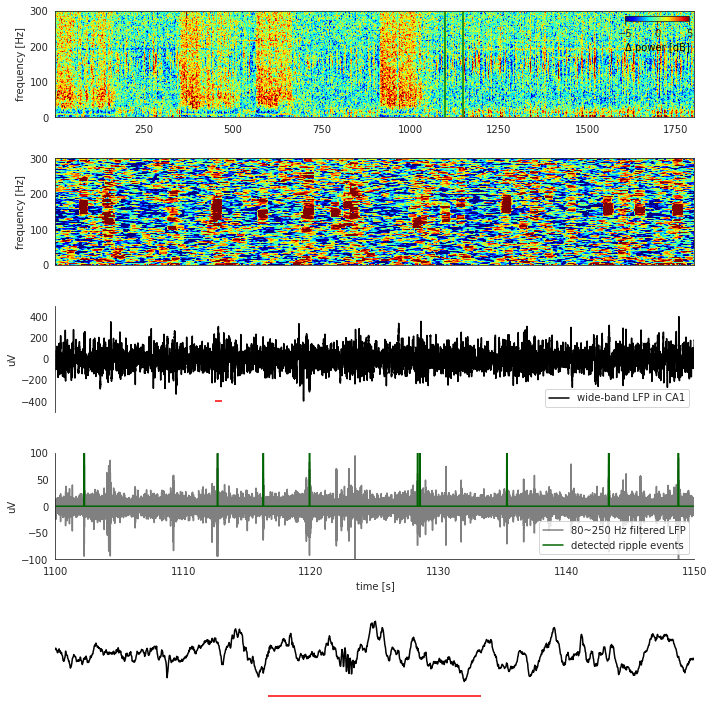

In [19]:
segrng = (1100,1150)
vrng = (0,300)
fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(10,10))
im2 = ax1.imshow(nlogSxx,cmap = 'jet',vmin= -5,vmax=5,aspect='auto', extent = [t[0], t[-1], f[-1], f[0]])
ax1.invert_yaxis()
ax1.set_ylim(vrng)
ax1.set_xlabel('')
ax1.set_ylabel('frequency [Hz]')
ax1.vlines(x=segrng,ymin=0,ymax=300,color='g')

axins2 = inset_axes(ax1, width="10%",  height="5%",loc='upper right')
cb = fig.colorbar(im2,cax=axins2,orientation='horizontal')
# cb.ax.xaxis.set_tick_params(color='w')
# cb.outline.set_edgecolor('w')
# plt.setp(plt.getp(cb.ax.axes, 'xticklabels'), color='w')
cb.set_label('\u0394 power [dB]', color='k')
#
ax2.imshow(nlogSxx,cmap = 'jet',vmin= -5,vmax=5,aspect='auto', extent = [t[0], t[-1], f[-1], f[0]])
ax2.invert_yaxis()
ax2.set_ylim(vrng)
ax2.set_ylabel('frequency [Hz]')
ax2.set_xticklabels([])
ax2.set_xlim(segrng)

#
ax3.plot(lfp0CA1.time,lfp0CA1[:,11]*1e6,'k',label='wide-band LFP in CA1')
ax3.set_xlim(segrng)
ax3.set_ylim(-500,500)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.set_ylabel('uV')
ax3.hlines(y=-400,xmin=1112.5,xmax=1113,color='r')
ax3.set_xticklabels([])
ax3.legend()
#
ax4.plot(lfp0CA1.time,sig*1e6,'gray',label='80~250 Hz filtered LFP')
ax4.plot(lfp0CA1.time,(rpexpmsk[11]!=0)*1e2,'darkgreen',label='detected ripple events')
ax4.set_xlim(segrng)
ax4.set_ylim(-100,100)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
ax4.set_ylabel('uV')
ax4.set_xlabel('time [s]')
ax4.legend()
#
ax5.plot(lfp0CA1.time,lfp0CA1[:,11]*1e6,'k')
ax5.set_xlim(1112,1113.5)
ax5.set_ylim(-500,500)
ax5.axis('off')
ax5.set_ylabel('uV')
ax5.set_xticklabels([])
ax5.hlines(y=-400,xmin=1112.5,xmax=1113,color='r')

fig.tight_layout(pad=1)


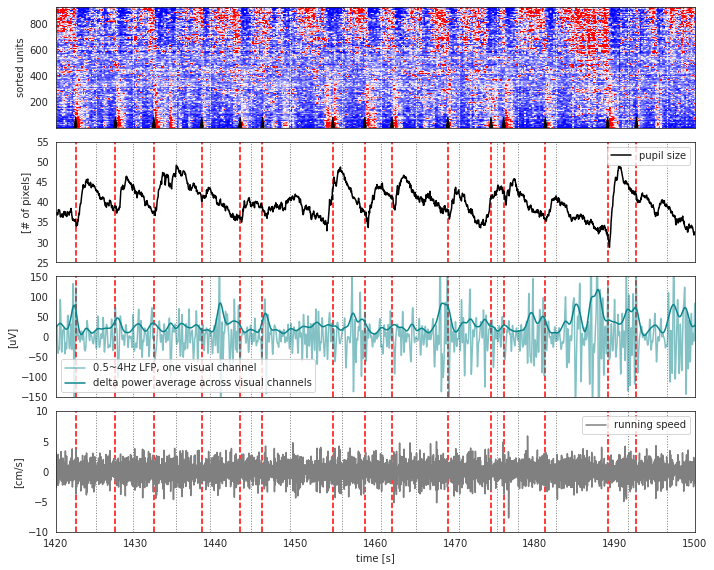

In [20]:
segrng = (1420,1500)#(1230,1310)
vrng = (0,2.5)
sns.set_style('white')
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(10,8))
ax1.imshow(rsData.spikect2[:,rsData.sind].T, cmap = 'bwr', 
           vmin=vrng[0], vmax=vrng[1], aspect= 'auto',
           extent = [rsData.gls.time_relative_to_stimulus_onset[0], 
                     rsData.gls.time_relative_to_stimulus_onset[-1], 1, rsData.spikect2.shape[1]] )
ax1.set_xlim(segrng)
ax1.set_xticks([])
# ax1.set_xlabel('time [s]')
ax1.set_ylabel('sorted units')
ax1.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[rsData.npks],
           ymin=1,ymax=rsData.spikect2.shape[1],color='w',linestyle='dotted',linewidth=1)
# ax1.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[posonsetind],ymin=1,ymax=rsData.spikect2.shape[1],color='lightgreen',linestyle='-')
posonsetind2 = posonsetind[(rsData.gls.time_relative_to_stimulus_onset[posonsetind]<segrng[1]) & \
                           (rsData.gls.time_relative_to_stimulus_onset[posonsetind]>segrng[0])]
for item in posonsetind2:
    ax1.arrow(rsData.spikect2.time_relative_to_stimulus_onset[item],1,0,1,head_length=80,head_width=.4,color='k')
#
ax2.plot(rsData.pupil_time,rsData.pupil_size,'k',label = 'pupil size')
ax2.set_xlim(segrng)
ax2.set_xticks([])
ax2.set_ylim((25,55))
ax2.set_ylabel('[# of pixels]')
ax2.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[rsData.npks],
           ymin=1,ymax=rsData.spikect2.shape[1],color='gray',linestyle='dotted',linewidth=1)
ax2.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[posonsetind],
           ymin=1,ymax=rsData.spikect2.shape[1],color='r',linestyle='--',linewidth=1.5)
ax2.legend()

#
ax3.plot(lfp0VISflt[:,0].time, lfp0VISflt[:,0]*1e6,
         color=np.array(colormap[acrnm_map['VIS']])/255,
         alpha=0.5,label='0.5~4Hz LFP, one visual channel')
ax3.plot(lfpData.rs_lfpVISdp[:,0].time,lfpData.rs_lfpVISdp[:,0]*1e6,
         color=np.array(colormap[acrnm_map['VIS']])/255,
         label='delta power average across visual channels')
# ax3.plot(lfpData.rs_lfpVISdp[:,0].time,dpw*1e6,color='k')
ax3.set_xlim(segrng)
ax3.set_ylim((-150,150))
ax3.set_xticks([])
ax3.set_ylabel('[uV]')
ax3.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[rsData.npks],
           ymin=-150,ymax=150,color='gray',linestyle='dotted',linewidth=1)
ax3.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[posonsetind],
           ymin=-150,ymax=150,color='r',linestyle='--',linewidth=1.5)
ax3.legend()
#
ax4.plot(rsData.running_time,rsData.running_speed,'gray',label='running speed')
ax4.set_xlim(segrng)
ax4.set_ylim((-10,10))
# ax4.set_xlabel('time [s]')
ax4.set_ylabel('[cm/s]')
ax4.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[rsData.npks],
           ymin=-10,ymax=10,color='gray',linestyle='dotted',linewidth=1)
ax4.vlines(x=rsData.spikect2.time_relative_to_stimulus_onset[posonsetind],
           ymin=-10,ymax=10,color='r',linestyle='--',linewidth=1.5)
ax4.set_xlabel('time [s]')
ax4.legend()
fig.tight_layout(pad=1)

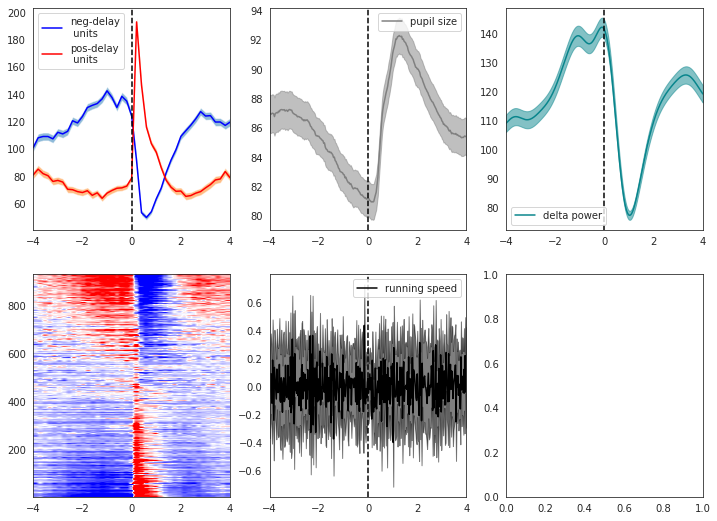

In [21]:
fig,axes = plt.subplots(2,3,figsize =(12,9))

ax = axes[0,0]
ax.plot(time_segct,AmpF*negmean,'b',label='neg-delay\n units')
ax.fill_between(time_segct,AmpF*(negmean-negseg.std(axis=1)/np.sqrt(negseg.shape[1])),\
                     AmpF*(negmean+negseg.std(axis=1)/np.sqrt(negseg.shape[1])),alpha =0.5)
ax.plot(time_segct,AmpF*posmean,'r',label='pos-delay\n units')
ax.fill_between(time_segct,AmpF*(posmean-posseg.std(axis=1)/np.sqrt(posseg.shape[1])),\
                     AmpF*(posmean+posseg.std(axis=1)/np.sqrt(posseg.shape[1])),alpha =0.5)
ax.set_xlim((-4,4))
ax.axvline(0,color='k',linestyle='--')
ax.legend(loc='upper left')

ax = axes[0,1]
ax.plot(time_segpupil,AmpF*pmean,'gray',label='pupil size')
ax.fill_between(time_segpupil,AmpF*(pmean-pupilseg.std(axis=1)/np.sqrt(pupilseg.shape[1])),\
                     AmpF*(pmean+pupilseg.std(axis=1)/np.sqrt(pupilseg.shape[1])),\
                    color = 'gray',alpha =0.5)
ax.set_xlim((-4,4))
ax.axvline(0,color='k',linestyle='--')
ax.legend()
      
ax = axes[0,2]
ax.plot(time_segdp,AmpF*dpmean,color=np.array(colormap[acrnm_map['VIS']])/255,label='delta power')
ax.fill_between(time_segdp,AmpF*(dpmean-dpseg.std(axis=1)/np.sqrt(dpseg.shape[1])),\
                     AmpF*(dpmean+dpseg.std(axis=1)/np.sqrt(dpseg.shape[1])),\
                         color = np.array(colormap[acrnm_map['VIS']])/255,alpha =0.5)
ax.set_xlim((-4,4))
ax.axvline(0,color='k',linestyle='--')
ax.legend()

ax = axes[1,0]
ax.imshow(segmean[:,rsData.sind].T,vmin = 0.5, vmax = 1.5,cmap = 'bwr',aspect='auto', 
                 extent=[-4,4,1,sessData.unitid.size])

ax = axes[1,1]
ax.plot(time_segrun,rmean,'k',label='running speed')
ax.fill_between(time_segrun,(rmean-runseg.std(axis=1)/np.sqrt(runseg.shape[1])),\
                     (rmean+runseg.std(axis=1)/np.sqrt(runseg.shape[1])),\
                         color = 'k',alpha =0.5)
ax.set_xlim((-4,4))
ax.axvline(0,color='k',linestyle='--')
ax.legend()


### PCA

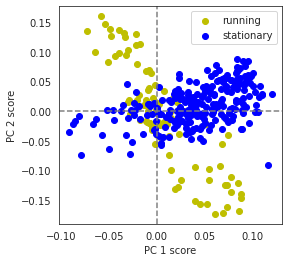

In [22]:
segrunmsk = rsData.qtmsk[rsData.glspksind]

colordic = {0:'y', 1:'b'}

fig,ax = plt.subplots(1,1,figsize =(4,4))

ax.scatter(rsData.Vh[0,segrunmsk==0],rsData.Vh[1,segrunmsk==0],c='y',label='running')
ax.scatter(rsData.Vh[0,segrunmsk==1],rsData.Vh[1,segrunmsk==1],c='b',label='stationary')
ax.axvline(0,color='gray',linestyle='--')
ax.axhline(0,color='gray',linestyle='--')
ax.set_xlabel('PC 1 score')
ax.set_ylabel('PC 2 score')
ax.legend()

### Stimulus Response

In [23]:
rspp_thr=0.001
corr_res = pd.DataFrame()
dgrdf = pd.DataFrame()
dgrtc_all = list()

corrthr = np.tanh(stats.norm.ppf(1 - pthr_corr/2) / np.sqrt(sum(rsData.glsnind)  - 3))

dprfsn_sgnf = rsData.dprfsn[:,rsData.dlycor>corrthr]
delay_tscore, delay_signp = stats.ttest_1samp(dprfsn_sgnf.T, 0)
delay_signp = delay_signp * np.sign(delay_tscore)

twin = 15
time_segct = (np.arange(2*twin) - twin) * rsData.tstep
spkctseg = extract_seg(rsData.spikect2, rsData.glspksind, twin)
segmean = spkctseg[:,:,rsData.dlycor>corrthr].mean(axis=2)
segpks = np.argmax(segmean, axis=0)
segtime = (np.arange(segmean.shape[0]) - int(segmean.shape[0]/2)) * rsData.tstep

lm = stats.linregress(rsData.U[:,0],segtime[segpks])
delay_sec = rsData.U[:,0] * lm.slope

time_dgr = dgrData.tbins[:-1] + dgrData.tstep / 2

ctrlmsk = (time_dgr<0)&(time_dgr>-0.8)
presmsk = (time_dgr<0)&(time_dgr>-0.2)
stimmsk = (time_dgr>0)
stimmsk2 = (time_dgr>0)&(time_dgr<0.4)
stimmsk3 = (time_dgr>0.4)&(time_dgr<10)

for contrast in dgrData.stimTable['contrast'].unique():
    for orientation in dgrData.stimTable['orientation'].unique():

        submsk = (dgrData.stimTable['orientation']==orientation) & (dgrData.stimTable['contrast']==contrast)
        dgrstim2 = dgrData.stimTable[submsk].copy()
        spikect_dgr_seg = dgrData.spikect[submsk,:,:].copy()

        spikect_dgr_stim = spikect_dgr_seg[:,stimmsk,:].mean(axis=1) 
        spikect_dgr_stim2 = spikect_dgr_seg[:,stimmsk2,:].mean(axis=1) 
        spikect_dgr_stim3 = spikect_dgr_seg[:,stimmsk3,:].mean(axis=1) 
        spikect_dgr_ctrl = spikect_dgr_seg[:,ctrlmsk,:].mean(axis=1)
        spikect_dgr_rsp = spikect_dgr_stim - spikect_dgr_ctrl

        dgrrspt,dgrrspp = stats.ttest_1samp(spikect_dgr_rsp, 0)
        dgrsind = np.argsort(dgrrspt)

        negumsk = (delay_signp<0) & (delay_signp>-pthr_mean) & (dgrrspp>0.05)
        posumsk = (delay_signp>0) & (delay_signp<pthr_mean) & (dgrrspp>0.05)
        dgrumsk = (dgrrspp<rspp_thr) & (abs(delay_signp)>0.05) & (dgrrspt>0)

        tmp1 = spikect_dgr_seg[:,:,negumsk].mean(axis=2)
        tmp2 = spikect_dgr_seg[:,:,posumsk].mean(axis=2)
        tmp1 = tmp1[:,presmsk]
        tmp2 = tmp2[:,presmsk]

        dgr_bldiff = tmp1.mean(axis=1) - tmp2.mean(axis=1)

        dgr_stim2 = spikect_dgr_stim2[:,dgrumsk].mean(axis=1)
        dgr_stim3 = spikect_dgr_stim3[:,dgrumsk].mean(axis=1)
        dgr_ctrl = spikect_dgr_ctrl[:,dgrumsk].mean(axis=1)
        dgr_rsp2 = dgr_stim2 - dgr_ctrl; 
        dgr_rsp3 = dgr_stim3 - dgr_ctrl; 

        dgr_stim2n = dgr_stim2 / dgr_ctrl.mean()
        dgr_stim3n = dgr_stim3 / dgr_ctrl.mean()
        dgr_ctrln = dgr_ctrl / dgr_ctrl.mean()
        dgr_rsp2n = dgr_stim2n - dgr_ctrln; 
        dgr_rsp3n = dgr_stim3n - dgr_ctrln; 

        dgrstim2['dgr_stim2'] = dgr_stim2
        dgrstim2['dgr_stim3'] = dgr_stim3
        dgrstim2['dgr_ctrl'] = dgr_ctrl
        dgrstim2['dgr_rsp2'] = dgr_rsp2
        dgrstim2['dgr_rsp3'] = dgr_rsp3

        dgrstim2['dgr_stim2n'] = dgr_stim2n
        dgrstim2['dgr_stim3n'] = dgr_stim3n
        dgrstim2['dgr_ctrln'] = dgr_ctrln
        dgrstim2['dgr_rsp2n'] = dgr_rsp2n
        dgrstim2['dgr_rsp3n'] = dgr_rsp3n

        dgrstim2['dgr_bldiff'] = dgr_bldiff
        dgrstim2['session_id'] = sid

        tmp = dgrstim2.iloc[:,-12:-1].corr().reset_index().iloc[:-1,[0, -1]]
        tmp['session_id'] = sid
        tmp['contrast'] = contrast
        tmp['orientation'] = orientation
        corr_res = corr_res.append(tmp)

        dgr_topr = spikect_dgr_seg[:,:,dgrumsk].mean(axis=2)
        dgr_topr_blcg = (dgr_bldiff>np.percentile(dgr_bldiff,33.33333)).astype(int) + \
                        (dgr_bldiff>np.percentile(dgr_bldiff,66.66667)).astype(int)

        dgrtc_all.append(dgr_topr.values)
        dgrstim2['dgr_topr_blcg'] = dgr_topr_blcg

        dgrdf = dgrdf.append(dgrstim2)

dgrtc_all = np.concatenate(dgrtc_all, axis=0).T

In [24]:
dgrexp=dgrdf[(dgrdf['contrast']==0.8)&(dgrdf['orientation']==90)]
dgrtc_exp = dgrtc_all[:,(dgrdf['contrast']==0.8)&(dgrdf['orientation']==90)]*20

dgrexp2 = dgrexp[dgrexp['session_id']==sid]
dgrtc_exp2 = dgrtc_exp[:,dgrexp['session_id']==sid]

dgr2_l_mean = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==0].mean(axis=1)
dgr2_l_se = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==0].std(axis=1)/np.sqrt((dgrexp2['dgr_topr_blcg']==0).sum())
dgr2_m_mean = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==1].mean(axis=1)
dgr2_m_se = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==1].std(axis=1)/np.sqrt((dgrexp2['dgr_topr_blcg']==1).sum())
dgr2_h_mean = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==2].mean(axis=1)
dgr2_h_se = dgrtc_exp2[:,dgrexp2['dgr_topr_blcg']==2].std(axis=1)/np.sqrt((dgrexp2['dgr_topr_blcg']==2).sum())


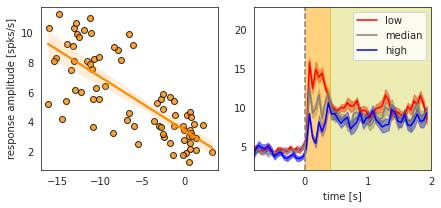

In [25]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7,3))
sns.regplot(data=dgrexp2*20,x='dgr_bldiff',y='dgr_rsp2',color='darkorange',ax=ax1,\
            line_kws = {'color':'darkorange'}, scatter_kws={'edgecolor':'k'})
ax1.set_ylabel('response amplitude [spks/s]')
ax1.set_xlabel('')
ax1.set_xlim(-17,4)

ax2.plot(time_dgr,dgr2_l_mean,color='r',label='low')
ax2.fill_between(time_dgr,dgr2_l_mean-dgr2_l_se,dgr2_l_mean+dgr2_l_se,color='r',alpha=0.5)
ax2.plot(time_dgr,dgr2_m_mean,color='gray',label='median')
ax2.fill_between(time_dgr,dgr2_m_mean-dgr2_m_se,dgr2_m_mean+dgr2_m_se,color='gray',alpha=0.5)
ax2.plot(time_dgr,dgr2_h_mean,color='b',label='high')
ax2.fill_between(time_dgr,dgr2_h_mean-dgr2_h_se,dgr2_h_mean+dgr2_h_se,color='b',alpha=0.5)

ax2.fill_between(np.linspace(0,0.4,100),0,30,color='orange',alpha=0.5)
ax2.fill_between(np.linspace(0.4,2,400),0,30,color='y',alpha=0.3)
ax2.legend()
ax2.set_xlabel('time [s]')
# ax2.set_ylabel('response')
ax2.set_xlim(-0.8,2)
ax2.set_ylim(2,23)
ax2.axvline(0,color='gray',linestyle='--')

### Running / Stationary Transition

In [26]:
d_qtmskorg = np.diff(rsData.qtmskorg)
rstart = np.where(d_qtmskorg==-1)[0]
rend = np.where(d_qtmskorg==1)[0]

runseg_start = extract_seg(rsData.running_speed,rstart,1600)
runseg_startm = runseg_start.mean(axis=1)
runseg_end = extract_seg(rsData.running_speed,rend,1600)
runseg_endm = runseg_end.mean(axis=1)

rstartind_spk = np.abs(np.subtract.outer(rsData.spikect.time_relative_to_stimulus_onset.values, 
                                         rsData.running_time[rstart])).argmin(0)
rendind_spk = np.abs(np.subtract.outer(rsData.spikect.time_relative_to_stimulus_onset.values, 
                                       rsData.running_time[rend])).argmin(0)

spkctseg_start = extract_seg(rsData.spikect2,rstartind_spk,200)
spkctseg_startm = spkctseg_start.mean(axis=2)
spkctseg_end = extract_seg(rsData.spikect2,rendind_spk,200)
spkctseg_endm = spkctseg_end.mean(axis=2)

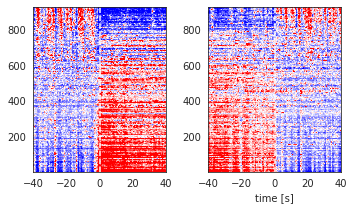

In [27]:
fig,axes = plt.subplots(1,2,figsize =(5,3))

axes[0].imshow(spkctseg_startm[:,rsData.sind].T, 
               vmin = 0.2, vmax = 1.8,cmap = 'bwr',aspect='auto', 
               extent=[-40,40,1,rsData.sind.size])
axes[0].vlines(0,ymin=1,ymax=930,linestyles='dashed',color='w')

axes[1].imshow(spkctseg_endm[:,rsData.sind].T,
               vmin = 0.2, vmax = 1.8,cmap = 'bwr',aspect='auto', 
               extent=[-40,40,1,rsData.sind.size])
axes[1].vlines(0,ymin=1,ymax=930,linestyles='dashed',color='w')  
axes[1].set_xlabel('time [s]')
fig.tight_layout(pad=1)

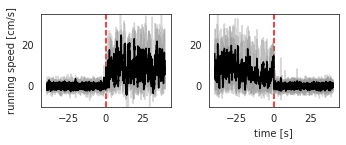

In [28]:
runsegtime = (np.arange(3201)-1600)/40

fig,axes = plt.subplots(1,2,figsize =(5,2))

axes[0].plot(runsegtime,runseg_start,'gray',alpha=.3)
axes[0].plot(runsegtime,runseg_startm,'k')
axes[0].vlines(0,ymin=-10,ymax=35,linestyles='dashed',color='r')
axes[0].set_ylim(-10,35)
axes[1].plot(runsegtime,runseg_end,'gray',alpha=.3)
axes[1].plot(runsegtime,runseg_endm,'k')
axes[1].vlines(0,ymin=-10,ymax=35,linestyles='dashed',color='r')
axes[1].set_ylim(-10,35)
axes[1].set_xlabel('time [s]')
axes[0].set_ylabel('running speed [cm/s]')
fig.tight_layout(pad=1)